Here we study how number of pairs change with the sky area of lenses.

In [72]:
# Standard imports
import copy
import corner
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Astropy imports
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.units import Quantity
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM

# SLSim imports
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.Lenses.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
from slsim.Lenses.lens import Lens
from slsim.LOS.los_pop import LOSPop

# Lenstronomy, HierArc imports
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from utils import run_pairing_simulation_from_data, fit_plane, find_scatter, pdspl_pairing_table_from_valid_pairs_table

In [73]:
# load the GGL data tables with different sky areas of lenses bu galaxy population is on 10 deg^2
sky_area = "5000.0"
# GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG.fits", format='fits')
GGL_data_table = Table.read(f"../data/norepeat_deflectors/GGL_5000.0_SQDEG_LSST_10yr.fits", format='fits')
GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
1,1.6461110256264142,4.25683755120038,0.5925540235916136,235.56963992911537,390379091508.3477,24.940791075067345,25.1969540378413,26.358258287728027,24.888474026014883,24.764572418155858,24.145590452880448,24.39913024189095,24.47096707143487,23.668001823865247,23.311871090978165,0.5913209870321624,0.158181845889771,-0.04880957837747978,0.1655411468804134,2,5.009158935093517,5102.452953253668,25.81182776257157
4,0.4992084355727959,3.161498679692048,0.9567126432867702,216.1359243673359,309900340847.3288,25.354170355804907,25.503541459263065,25.727086342933188,25.215881933592005,25.19122458805712,19.5103658917246,20.216346109142574,21.367709010780384,19.16476832839017,18.91135306718056,1.1115902537023898,0.008796761968147592,0.005711686228704975,0.010488392665200229,2,6.77964807152321,3196.018497061882,24.0606715980108
5,0.44670737442563785,2.2403077838670176,0.6182583894438882,176.35133159067124,164114327109.73065,23.987539195218687,24.074213837902732,24.20163412566813,23.890087591257142,23.7323237255968,19.830386656329406,20.44988333187086,21.795480254953358,19.511137688407718,19.29029383232294,0.6236752721238379,-0.00834751837384936,0.0361391151225497,0.03709065522261171,2,3.576974033944673,4031.524932511753,23.234258511482487
7,1.1687681550638929,2.826650018379998,1.652474103886779,377.3158206388067,1248346834139.14,24.83541503267986,25.134457362799687,25.452658842164396,24.665439748239606,24.499732117354746,21.93123799159734,23.071160777817074,24.234681882369383,21.11700711046006,20.406475017378607,1.0743917444354762,-0.17043015137015502,0.1038174696312703,0.19956077644841355,2,8.87452864700834,7365.066900372805,26.861469550194
8,1.6269287552529557,3.293459208446792,0.6348494170702866,267.81495105239617,541576037565.15216,23.95184989062291,24.04160456650827,24.2675085865084,23.877034858793422,23.83395521167202,23.95566911199722,24.383257422984943,24.50170246296685,23.36455058560549,22.95884816649205,0.6982793323505179,0.1524771685118006,-0.0140809740436967,0.15312596366193193,2,5.915885598210209,5589.8038034287165,26.185503502500755
9,0.4723708262898711,2.752961849737639,0.6092610392880263,173.02062362354164,153241093081.24084,25.27985184079253,25.529897393245832,25.711363912828567,25.218283123113174,25.120699216104953,20.21943977382547,20.98410384833246,22.481158504799588,19.86311316738594,19.649969975361984,0.41592840451861934,0.21541893759505717,-0.1822233986640161,0.28215365617912536,2,2.4617042682239965,5523.929178722648,23.071148771959173
10,0.6018575718225225,3.779641836616279,0.9391246758768964,218.10310439063903,315981942577.1457,25.24985661316691,25.265389127211062,25.80849890621312,25.140727157188895,25.074633632511453,20.310381433685464,21.406786003126122,22.888570552333846,19.898398416764067,19.585106474271754,0.4810583064055838,-0.030919891219066412,-0.5113059556691136,0.512240002318937,2,3.220717208715686,6349.906181935916,23.933708767316734
13,1.2867208089578022,4.103173080792566,1.5594504001793026,344.7825010896406,1005917163256.4558,25.986310697707232,26.001990782927464,26.88681244268134,25.88184841862025,25.879179568872523,22.6832605659137,23.342232162922564,23.510322737822314,22.07593541091064,21.312226798975097,1.0380116936028003,-0.04413412399084177,0.012263591049369164,0.04580629395470848,2,8.686599498145446,6344.294793755491,26.09016775607049
14,0.39794346359866317,2.4373187597039783,0.8142462392764771,196.44905480643382,236228944345.16626,25.8633168672797,25.943518308980188,26.040718712403127,25.89002589052145,25.822927609101818,19.29815147392111,19.93716517577188,21.45478866111752,18.947372100045

In [74]:
sky_areas = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000]  # deg^2 # max is 1000 deg^2 from the data
fraction_of_max = np.array(sky_areas)/max(sky_areas)

cosmo_true = FlatLambdaCDM(H0=70, Om0=0.3)

GGL_tables_at_different_areas = {}
for area in sky_areas:
    # randomly select the fraction of rows corresponding to the sky area
    num_rows = int(len(GGL_data_table) * (area / max(sky_areas)))
    table = GGL_data_table[np.random.choice(len(GGL_data_table), num_rows, replace=False)]
    GGL_tables_at_different_areas[area] = table

num_pairs_at_different_areas = []
scatter_in_beta_E_at_different_areas = []
for area in sky_areas:
    table = GGL_tables_at_different_areas[area]
    num_pairs, valid_pairs_table = run_pairing_simulation_from_data(table, threshold_rel_delta_z=0.01, 
                                     verbose=True)

    pairing_table = pdspl_pairing_table_from_valid_pairs_table(valid_pairs_table, table, cosmo_true)

    scatter_in_beta_E = np.std(1 - pairing_table["beta_E_pseudo"]/pairing_table["beta_E_DSPL"])

    num_pairs_at_different_areas.append(num_pairs)
    scatter_in_beta_E_at_different_areas.append(scatter_in_beta_E)


--- Running simulation for 79 lenses ---
x_std: 0.1957344683906915, y_std: 0.14497222136396912
Using bin widths of 0.23 in x and 0.17 in y for pairing.
Using 5 bins in x and 4 bins in y for pairing.
Finding pairs in the binned data...
Found 4 pairs.

--- Running simulation for 199 lenses ---
x_std: 0.21665153552203967, y_std: 0.12388104544256864
Using bin widths of 0.20 in x and 0.12 in y for pairing.
Using 7 bins in x and 7 bins in y for pairing.
Finding pairs in the binned data...
Found 29 pairs.

--- Running simulation for 399 lenses ---
x_std: 0.22195325170672672, y_std: 0.12951006147975047
Using bin widths of 0.17 in x and 0.10 in y for pairing.
Using 8 bins in x and 9 bins in y for pairing.
Finding pairs in the binned data...
Found 91 pairs.

--- Running simulation for 798 lenses ---
x_std: 0.228078404918478, y_std: 0.1324714991110648
Using bin widths of 0.15 in x and 0.09 in y for pairing.
Using 10 bins in x and 12 bins in y for pairing.
Finding pairs in the binned data...
Foun

/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:221: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta_DSPL = beta_double_source_plane(
/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:221: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta_DSPL = beta_double_source_plane(
/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:221: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta_DSPL = beta_double_source_plane(
/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:221: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionall

Found 812 pairs.


/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:221: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta_DSPL = beta_double_source_plane(



--- Running simulation for 3990 lenses ---
x_std: 0.2134877626810043, y_std: 0.13233346439503943
Using bin widths of 0.09 in x and 0.06 in y for pairing.
Using 17 bins in x and 17 bins in y for pairing.
Finding pairs in the binned data...
Found 2713 pairs.


/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:221: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta_DSPL = beta_double_source_plane(



--- Running simulation for 7980 lenses ---
x_std: 0.2161528537910024, y_std: 0.12994799753861466
Using bin widths of 0.08 in x and 0.05 in y for pairing.
Using 21 bins in x and 20 bins in y for pairing.
Finding pairs in the binned data...
Found 7016 pairs.


/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:221: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta_DSPL = beta_double_source_plane(



--- Running simulation for 19950 lenses ---
x_std: 0.21660546777464607, y_std: 0.1313464719322262
Using bin widths of 0.06 in x and 0.04 in y for pairing.
Using 28 bins in x and 28 bins in y for pairing.
Finding pairs in the binned data...
Found 29117 pairs.


/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:221: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta_DSPL = beta_double_source_plane(



--- Running simulation for 39900 lenses ---
x_std: 0.2172066531553569, y_std: 0.13178741026420193
Using bin widths of 0.05 in x and 0.03 in y for pairing.
Using 35 bins in x and 36 bins in y for pairing.
Finding pairs in the binned data...
Found 81750 pairs.


/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:221: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta_DSPL = beta_double_source_plane(


Text(0.5, 1.0, 'Number of Deflector Pairs w/in 1% Redshift on MFP')

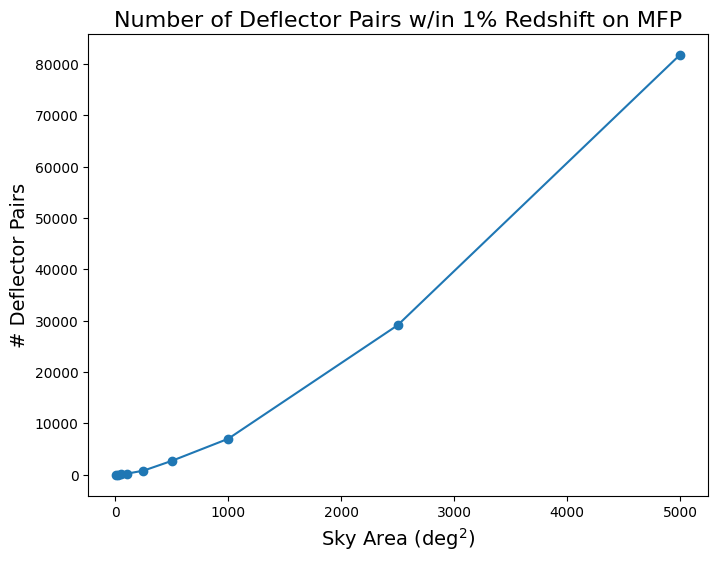

In [75]:
# plot the number of pairs vs sky area
plt.figure(figsize=(8, 6))
plt.plot(sky_areas, num_pairs_at_different_areas, 'o-')
plt.xlabel("Sky Area (deg$^2$)", fontsize=14)
plt.ylabel("# Deflector Pairs", fontsize=14)
plt.title("Number of Deflector Pairs w/in 1% Redshift on MFP", fontsize=16)
# plt.xscale('log')
# plt.yscale('log')


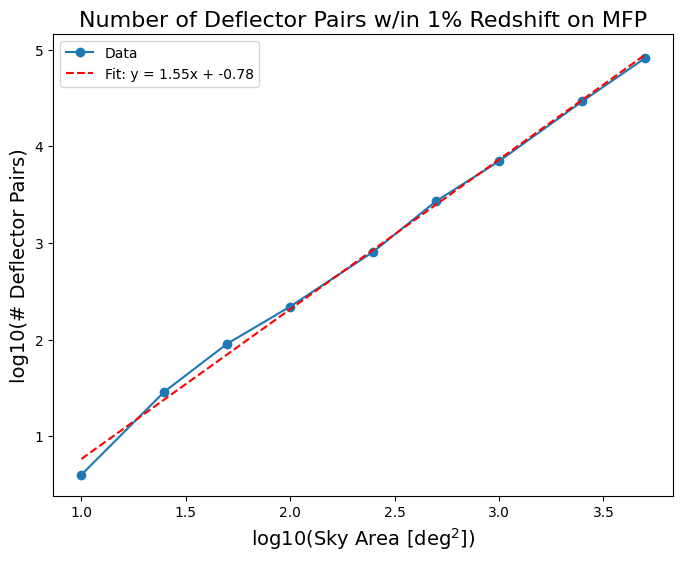

In [76]:
# plot the number of pairs vs sky area
plt.figure(figsize=(8, 6))

# fit a line to the log-log data
log_sky_areas = np.log10(sky_areas)
log_num_pairs = np.log10(num_pairs_at_different_areas)
slope, intercept = np.polyfit(log_sky_areas, log_num_pairs, 1)
x_fit = np.linspace(min(log_sky_areas), max(log_sky_areas), 100)
y_fit = slope * x_fit + intercept


plt.plot(log_sky_areas, log_num_pairs, 'o-', label='Data')
plt.xlabel("log10(Sky Area [deg$^2$])", fontsize=14)
plt.ylabel("log10(# Deflector Pairs)", fontsize=14)
plt.title("Number of Deflector Pairs w/in 1% Redshift on MFP", fontsize=16)


plt.plot(x_fit, y_fit, 'r--', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}') 
plt.legend()

Text(0, 0.5, 'scatter in $\\beta_E$')

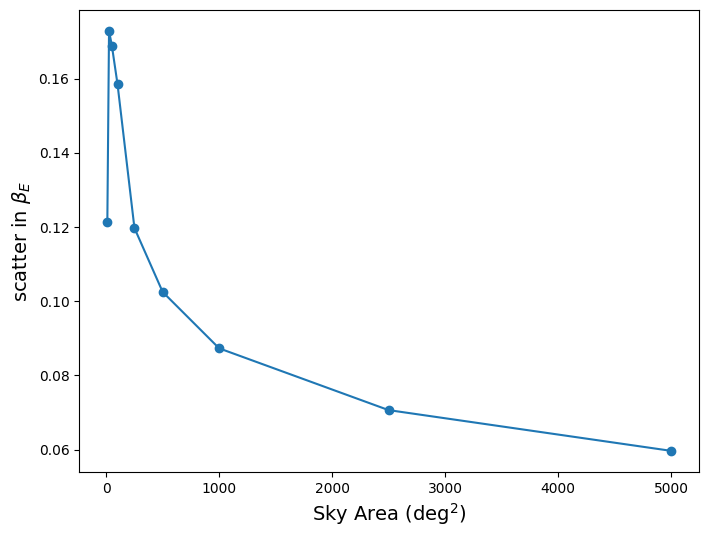

In [77]:
# plot scatter in beta_E vs sky area
plt.figure(figsize=(8, 6))
plt.plot(sky_areas, scatter_in_beta_E_at_different_areas, 'o-')
plt.xlabel("Sky Area (deg$^2$)", fontsize=14)
plt.ylabel("scatter in $\\beta_E$", fontsize=14)
# plt.xscale('log')
# plt.yscale('log')

Text(0.5, 1.0, 'Scatter in $\\beta_E$ vs Sky Area')

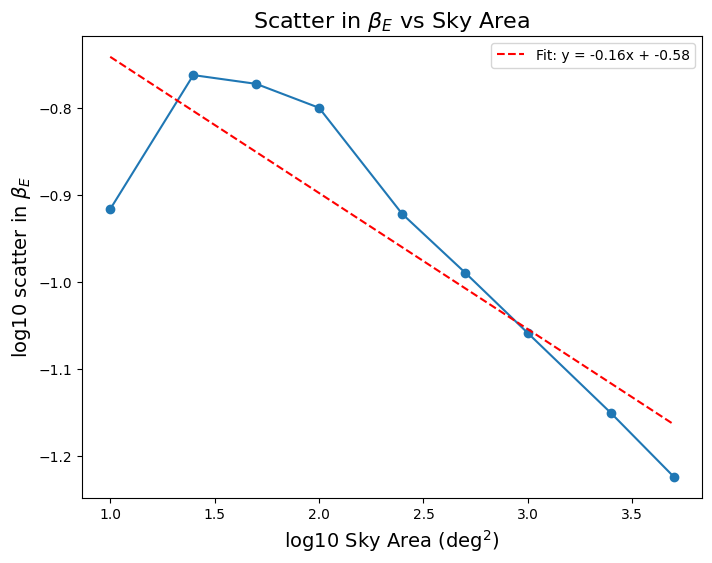

In [78]:
# plot scatter in beta_E vs sky area
plt.figure(figsize=(8, 6))
plt.plot(np.log10(sky_areas), np.log10(scatter_in_beta_E_at_different_areas), 'o-')
plt.xlabel("log10 Sky Area (deg$^2$)", fontsize=14)
plt.ylabel("log10 scatter in $\\beta_E$", fontsize=14)

# fit a line to the log-log data
m, b = np.polyfit(np.log10(sky_areas), np.log10(scatter_in_beta_E_at_different_areas), 1)
x_fit = np.linspace(np.log10(min(sky_areas)), np.log10(max(sky_areas)), 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'r--', label=f'Fit: y = {m:.2f}x + {b:.2f}')
plt.legend()
plt.title("Scatter in $\\beta_E$ vs Sky Area", fontsize=16)


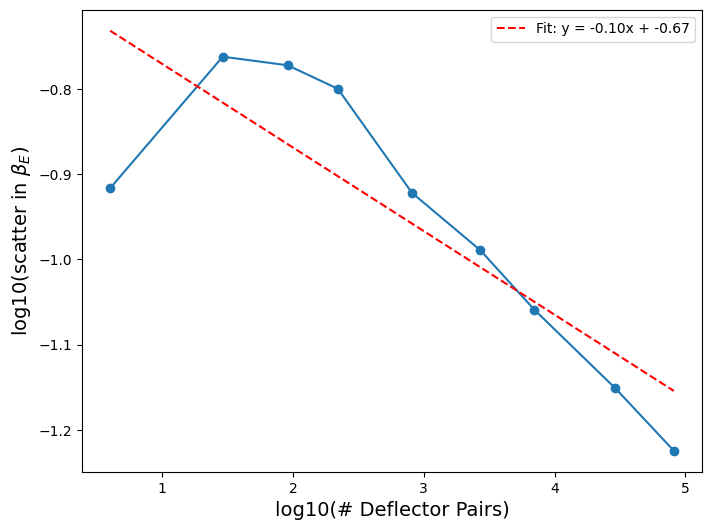

In [79]:
# scatter in beta_E with number of pairs
plt.figure(figsize=(8, 6))
plt.plot(np.log10(num_pairs_at_different_areas), np.log10(scatter_in_beta_E_at_different_areas), 'o-')
plt.xlabel("log10(# Deflector Pairs)", fontsize=14)
plt.ylabel("log10(scatter in $\\beta_E$)", fontsize=14)

# fit a line to the log-log data
m, b = np.polyfit(np.log10(num_pairs_at_different_areas), np.log10(scatter_in_beta_E_at_different_areas), 1)
x_fit = np.linspace(np.log10(min(num_pairs_at_different_areas)), np.log10(max(num_pairs_at_different_areas)), 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'r--', label=f'Fit: y = {m:.2f}x + {b:.2f}')
plt.legend()

Text(0.5, 1.0, 'Number of Deflector Pairs w/in 1% Redshift on MFP')

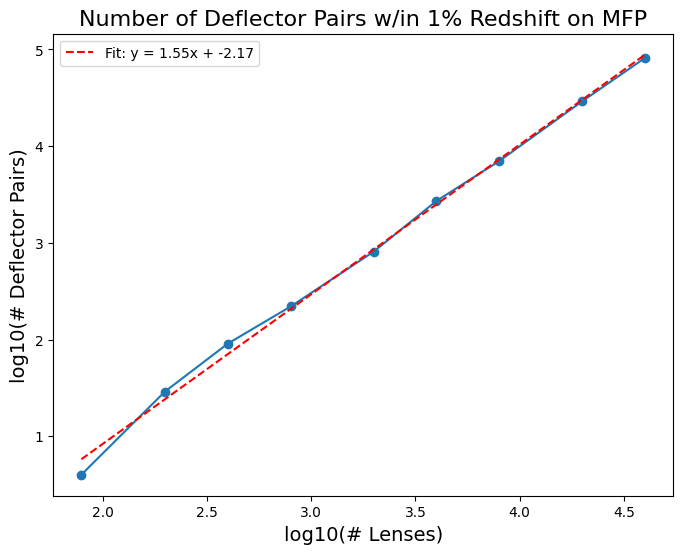

In [80]:
# num lenses vs num pairs
num_lenses_at_different_areas = [len(GGL_tables_at_different_areas[area]) for area in sky_areas]
plt.figure(figsize=(8, 6))
plt.plot(np.log10(num_lenses_at_different_areas), np.log10(num_pairs_at_different_areas), 'o-')
plt.xlabel("log10(# Lenses)", fontsize=14)
plt.ylabel("log10(# Deflector Pairs)", fontsize=14)
plt.title("Number of Deflector Pairs w/in 1% Redshift on MFP", fontsize=16)
# plt.xscale('log')
# plt.yscale('log')

# fit a line to the log-log data
m, b = np.polyfit(np.log10(num_lenses_at_different_areas), np.log10(num_pairs_at_different_areas), 1)
x_fit = np.linspace(np.log10(min(num_lenses_at_different_areas)), np.log10(max(num_lenses_at_different_areas)), 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'r--', label=f'Fit: y = {m:.2f}x + {b:.2f}')
plt.legend()
plt.title("Number of Deflector Pairs w/in 1% Redshift on MFP", fontsize=16)